## load Datasets

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler,StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import  CatBoostClassifier
from sklearn.metrics import accuracy_score


In [2]:

paths={}
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        directory=os.path.join(dirname, filename)
        name=filename.split(".")
        paths[name[0]]=directory
        

df_train=pd.read_csv(paths["train"])
df_test=pd.read_csv(paths["test"])
df_sub=pd.read_csv(paths["sample_submission"])
targets=df_train['NObeyesdad']

## EDA

## Meaning od Attributes

FAVC: Frequent consumption of high caloric food,

FCVC: Frequency of consumption of vegetables,

NCP: Number of main meals,

CAEC: Consumption of food between meals,

CH20: Consumption of water daily,

CALC: Consumption of alcohol.

SCC: Calories consumption monitoring,

FAF: Physical activity frequency,

TUE: Time using technology devices,

MTRANS: Transportation used.

Gender,

Age,

Height and Weight.


you can notice that some features are related to another for example FAVC and FCVC. We will analyze how we can manipulate feature from combination of attributes later in Feature engineering.

In [3]:
df_train.sample(5)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
12647,12647,Female,33.000000,1.680000,77.000000,yes,yes,2.000000,1.000000,Sometimes,no,1.000000,no,0.000000,2.000000,Sometimes,Automobile,Overweight_Level_II
11505,11505,Male,34.243146,1.719342,84.493156,yes,yes,2.000000,3.000000,Sometimes,no,2.371015,no,1.000000,0.175587,Sometimes,Automobile,Overweight_Level_II
4003,4003,Male,30.108216,1.825590,124.070717,yes,yes,2.499388,3.000000,Sometimes,no,2.040952,no,0.976425,0.561602,Sometimes,Public_Transportation,Obesity_Type_II
18654,18654,Female,18.000000,1.701986,85.000000,yes,yes,2.000000,1.941307,Sometimes,no,2.813530,no,1.000000,1.639326,no,Public_Transportation,Obesity_Type_I
11370,11370,Female,19.000000,1.520000,42.000000,no,no,3.000000,1.000000,Frequently,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Insufficient_Weight


In [4]:
df_train["NObeyesdad"].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

Notice that labels does not come in a particular order. to gain insight on progressive and scale nature of obesity risk. it is necessary to preserve contigency of obesity risk which in our case is about severity.

from WHO, definition of obesity: Overweight and obesity are defined as abnormal or excessive fat accumulation that presents a risk to health. 

Obesity is usually determined by The BMI( Body-Mass index) which is calculated by dividing an adult's weight in kilograms by their height in metres squared.

- We use domain knowledge to know the order. by heuristics, can get order of Obesity levels from engineered feature for BMI

- note that BMI alone does not predict Obesity. but it provides ground point for contigency.

- PS: It make sense to have Overweight near Obesity_type_II than Insufficient_weight near Obesity_type_II. 



In [5]:
# Calculate mean weight for each category of obesity risk
df_train["BMI"]=df_train["Weight"]/(df_train["Height"]**2)
mean_BMI = df_train.groupby("NObeyesdad")['BMI'].mean().sort_values().index.tolist()
mean_BMI

['Insufficient_Weight',
 'Normal_Weight',
 'Overweight_Level_I',
 'Overweight_Level_II',
 'Obesity_Type_I',
 'Obesity_Type_II',
 'Obesity_Type_III']

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [7]:
df_train.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756,30.241842
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113,8.333932
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000,12.868541
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000,24.088223
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887,29.384757
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000,37.011168
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000,54.997991


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Height'}>,
        <Axes: title={'center': 'Weight'}>],
       [<Axes: title={'center': 'FCVC'}>,
        <Axes: title={'center': 'NCP'}>,
        <Axes: title={'center': 'CH2O'}>],
       [<Axes: title={'center': 'FAF'}>, <Axes: title={'center': 'TUE'}>,
        <Axes: title={'center': 'BMI'}>]], dtype=object)

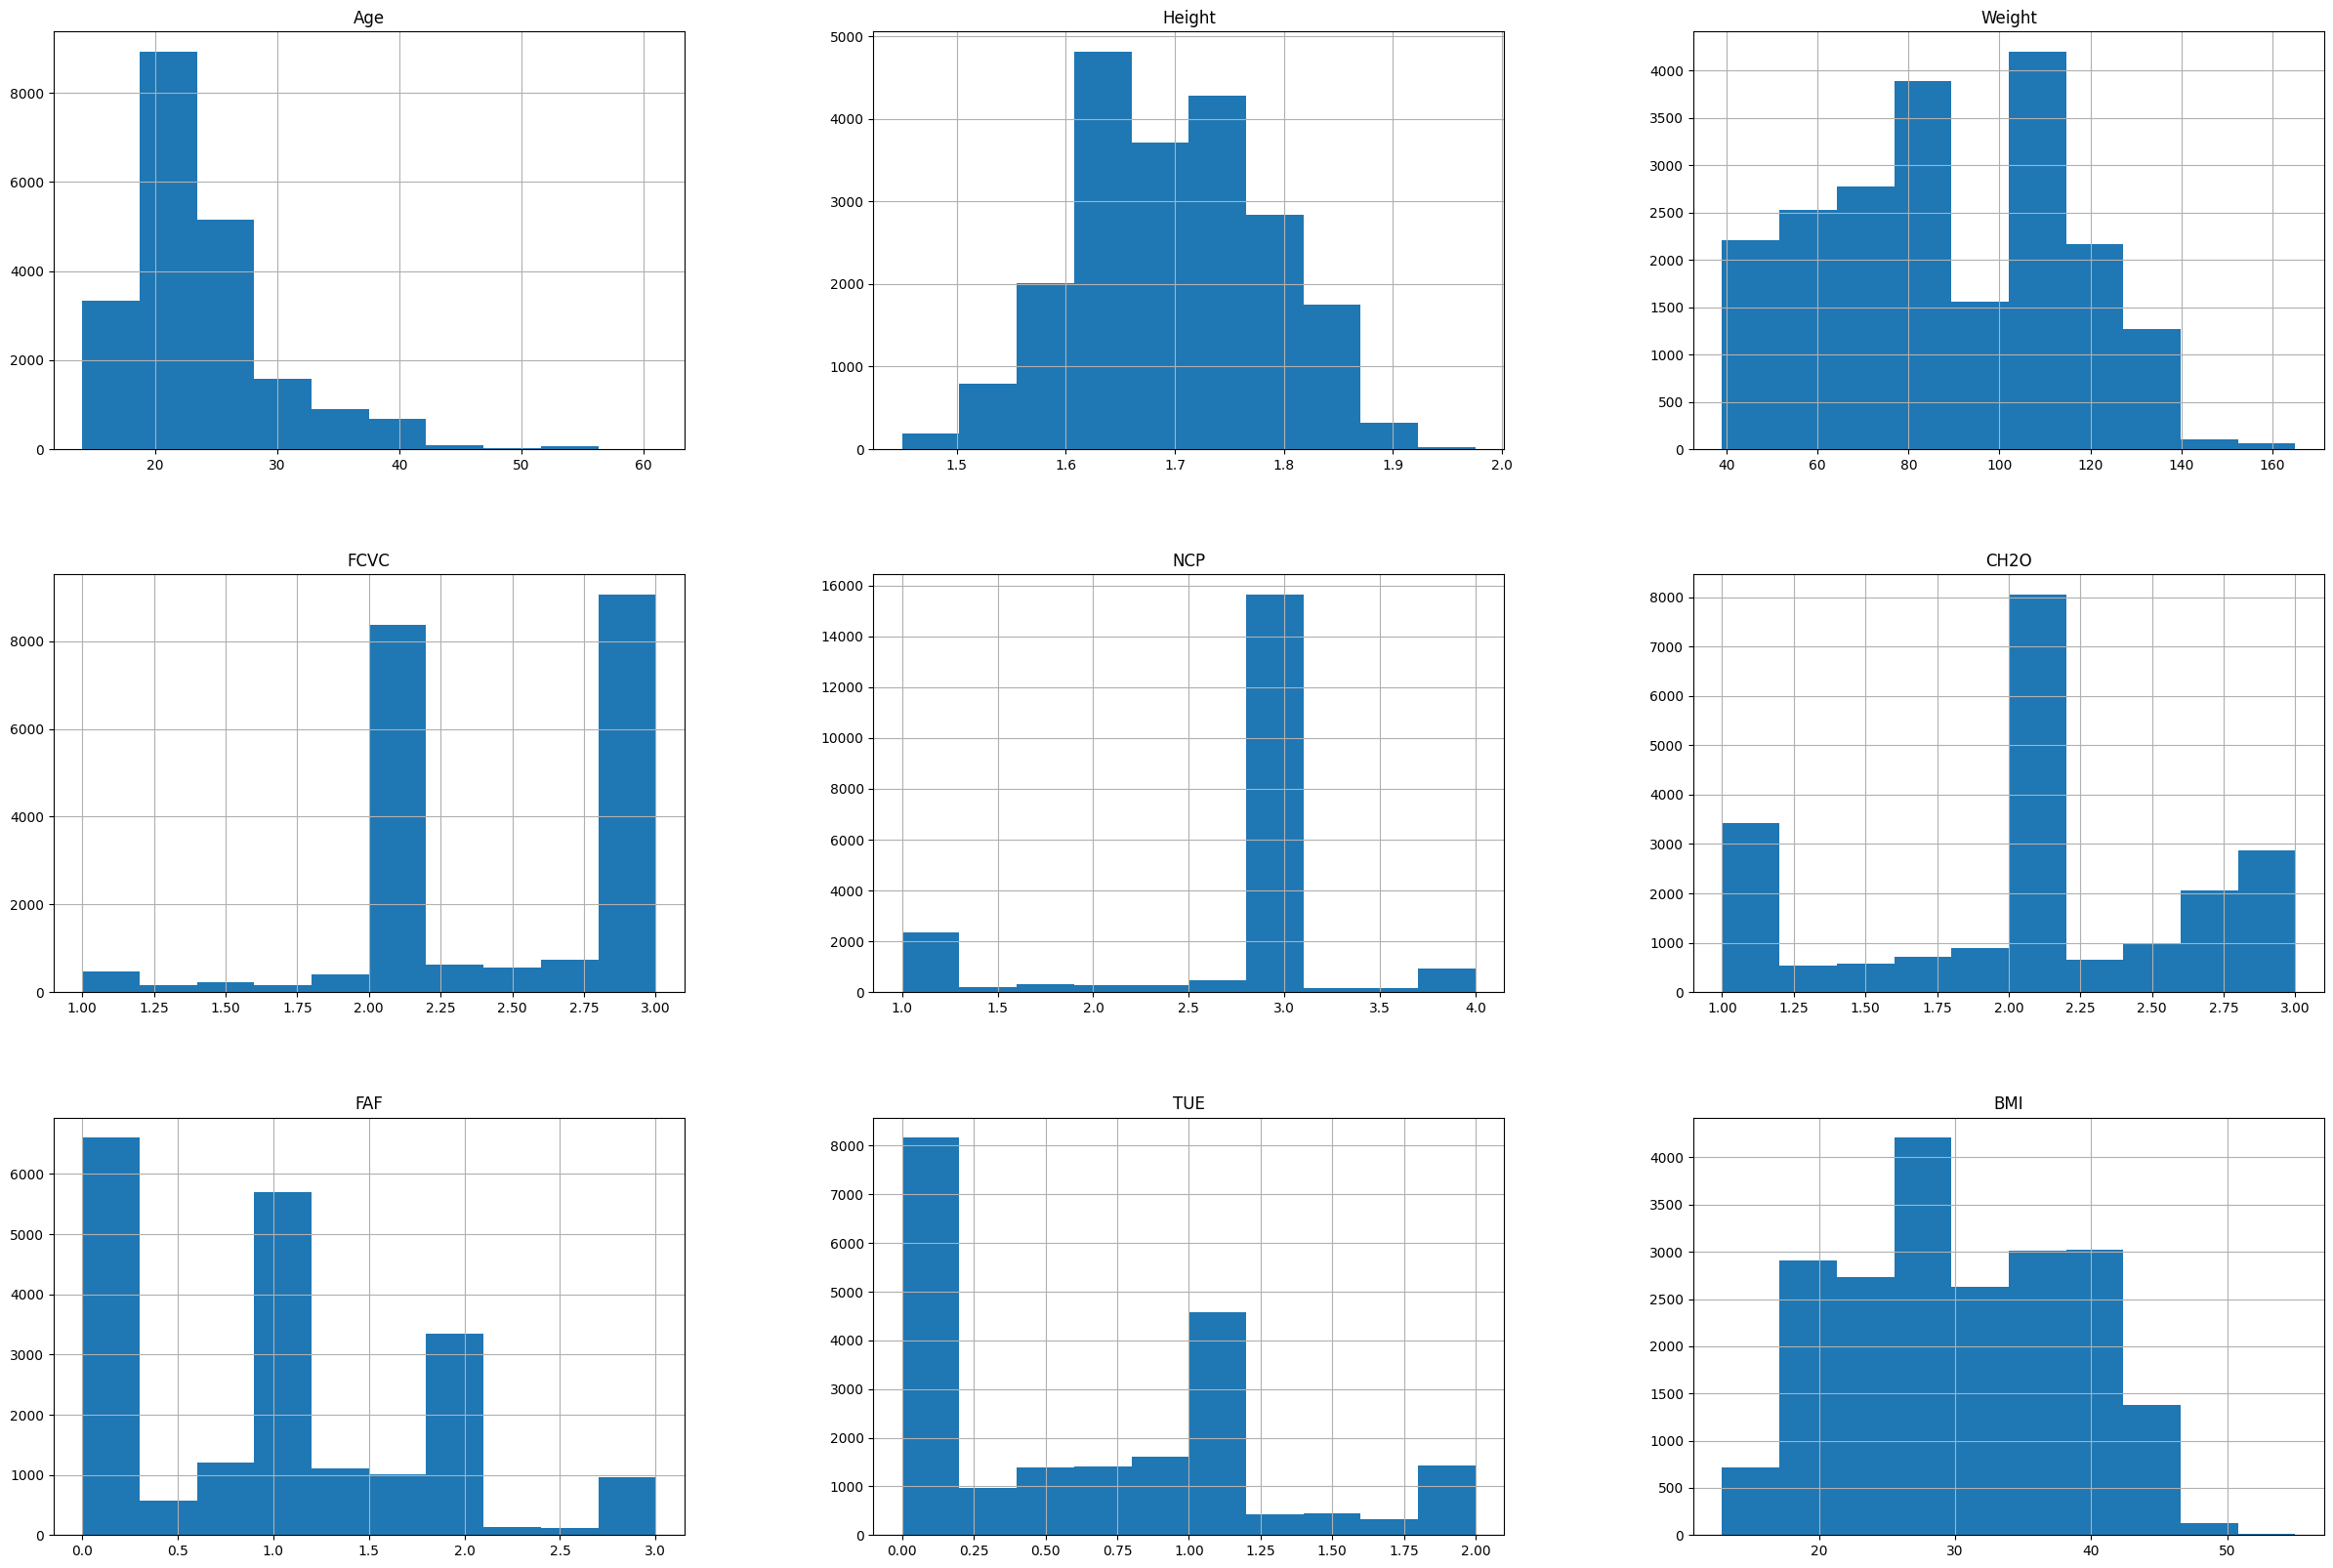

In [8]:
# Get numerical columns
numerical_columns = df_train.drop('id', axis=1).select_dtypes(include=['number']).columns.tolist()

df_train[numerical_columns].hist(figsize=(30, 20))

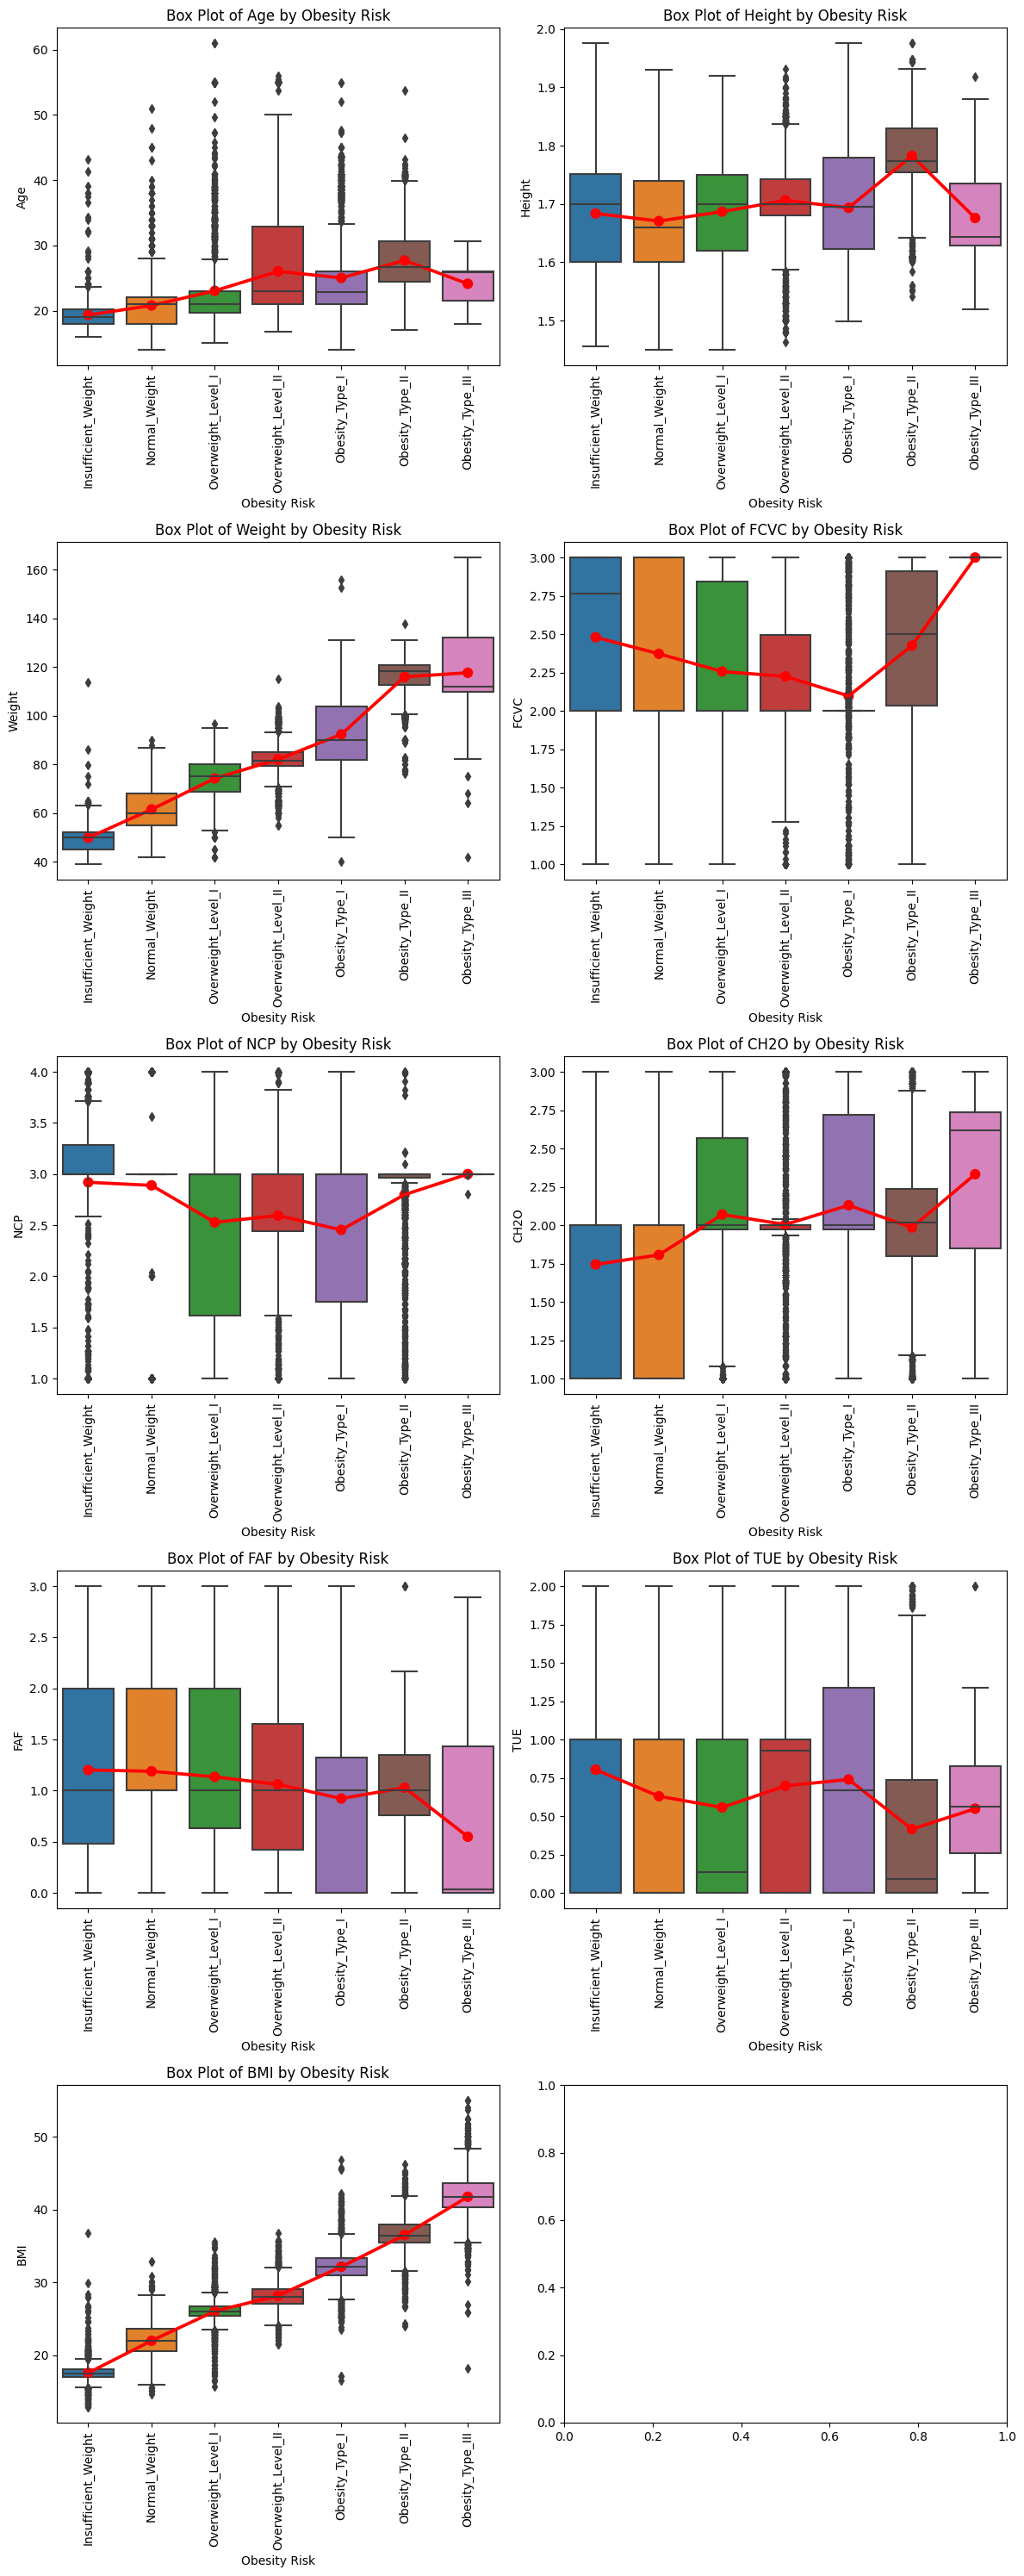

In [9]:

# Calculate number of rows and columns for subplots
num_plots = len(numerical_columns)
num_cols = 2
num_rows = math.ceil(num_plots / num_cols)

# Create subplots with specified height ratios
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 6), 
                         gridspec_kw={'height_ratios': [4] * num_rows})

# Plot box plots for each numerical column
for ax, column in zip(axes.flatten(), numerical_columns):
    sns.boxplot(x="NObeyesdad", y=column, data=df_train, ax=ax,order=mean_BMI)
    sns.pointplot(x="NObeyesdad", y=column, data=df_train, ax=ax, color='red', markers='o', linestyles='-', errorbar=None, order=mean_BMI)
    ax.set_title(f'Box Plot of {column} by Obesity Risk')
    ax.set_xlabel('Obesity Risk')
    ax.set_ylabel(column)
    ax.tick_params(axis='x', rotation=90)
    
plt.tight_layout()
plt.show()

From the Boxplot, you can see that the distribution varies at given numerical columns. Breakdown:

1) Age, height, CH2O, BMI: Mean and median increase for Obesity  levels

2) Weight: As predicted from out heuristics, Weight mean and median increase for Obesity levels

3) FCVC and NCP: Mean and median for FCVC and NCP have no correlation with Obesity levels

4) FAF and TUE: Mean for FAT and TUE  decreases for Obesity  levels.

From these we can ascertain that there are relations between features and Obesity levels.

Next, we check for correlation between features. 

<Axes: >

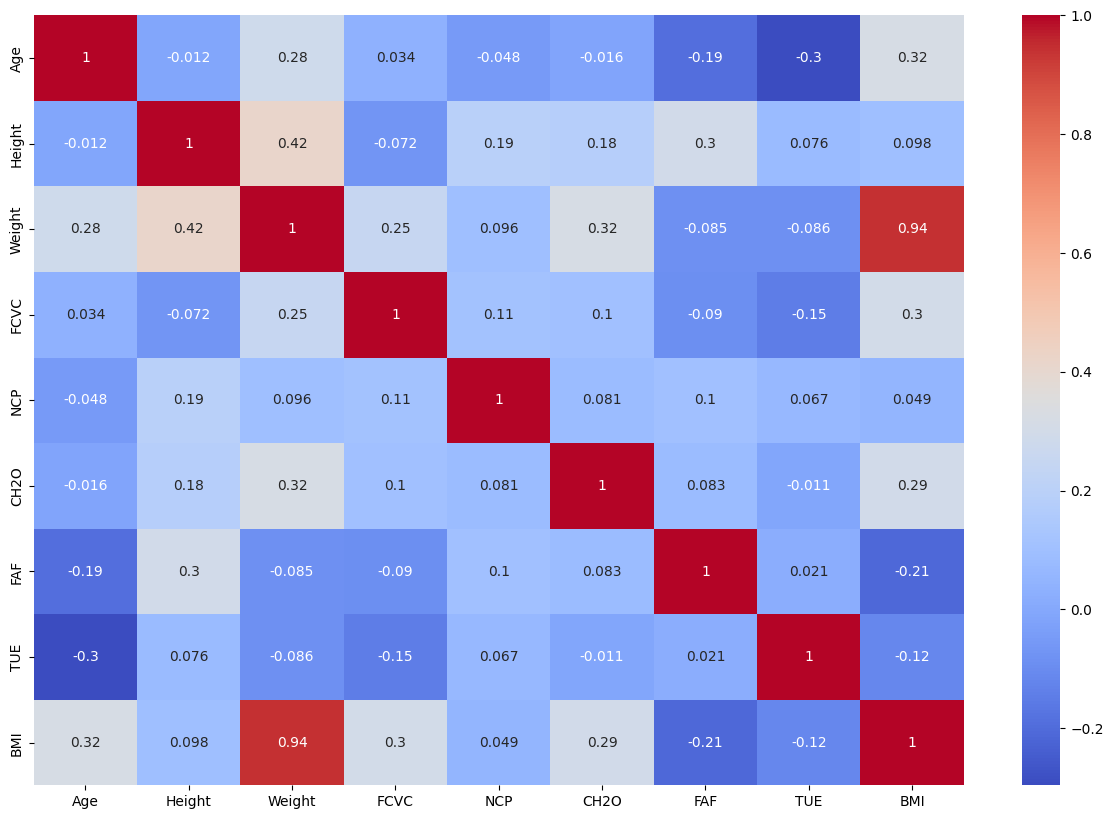

In [10]:
plt.figure(figsize=(15, 10))
data = df_train[numerical_columns]
sns.heatmap(data.corr(), cmap='coolwarm', annot=True)

We can see that there is high correlation between Weight and BMI(0.94), this is mostly because BMI is derived from Weight; Height and weight(0.42).

Two features being highly correlated with each other will provide too much and useless information on finding the target. 

ANalysis for non-numerical features

In [11]:
non_numerical_cols=df_train.drop(['id'], axis=1).drop(['NObeyesdad'], axis=1).select_dtypes(exclude=['number']).columns.tolist()

In [12]:
for col in non_numerical_cols:
    print(col, ": ", df_train[col].unique())

Gender :  ['Male' 'Female']
family_history_with_overweight :  ['yes' 'no']
FAVC :  ['yes' 'no']
CAEC :  ['Sometimes' 'Frequently' 'no' 'Always']
SMOKE :  ['no' 'yes']
SCC :  ['no' 'yes']
CALC :  ['Sometimes' 'no' 'Frequently']
MTRANS :  ['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']


4


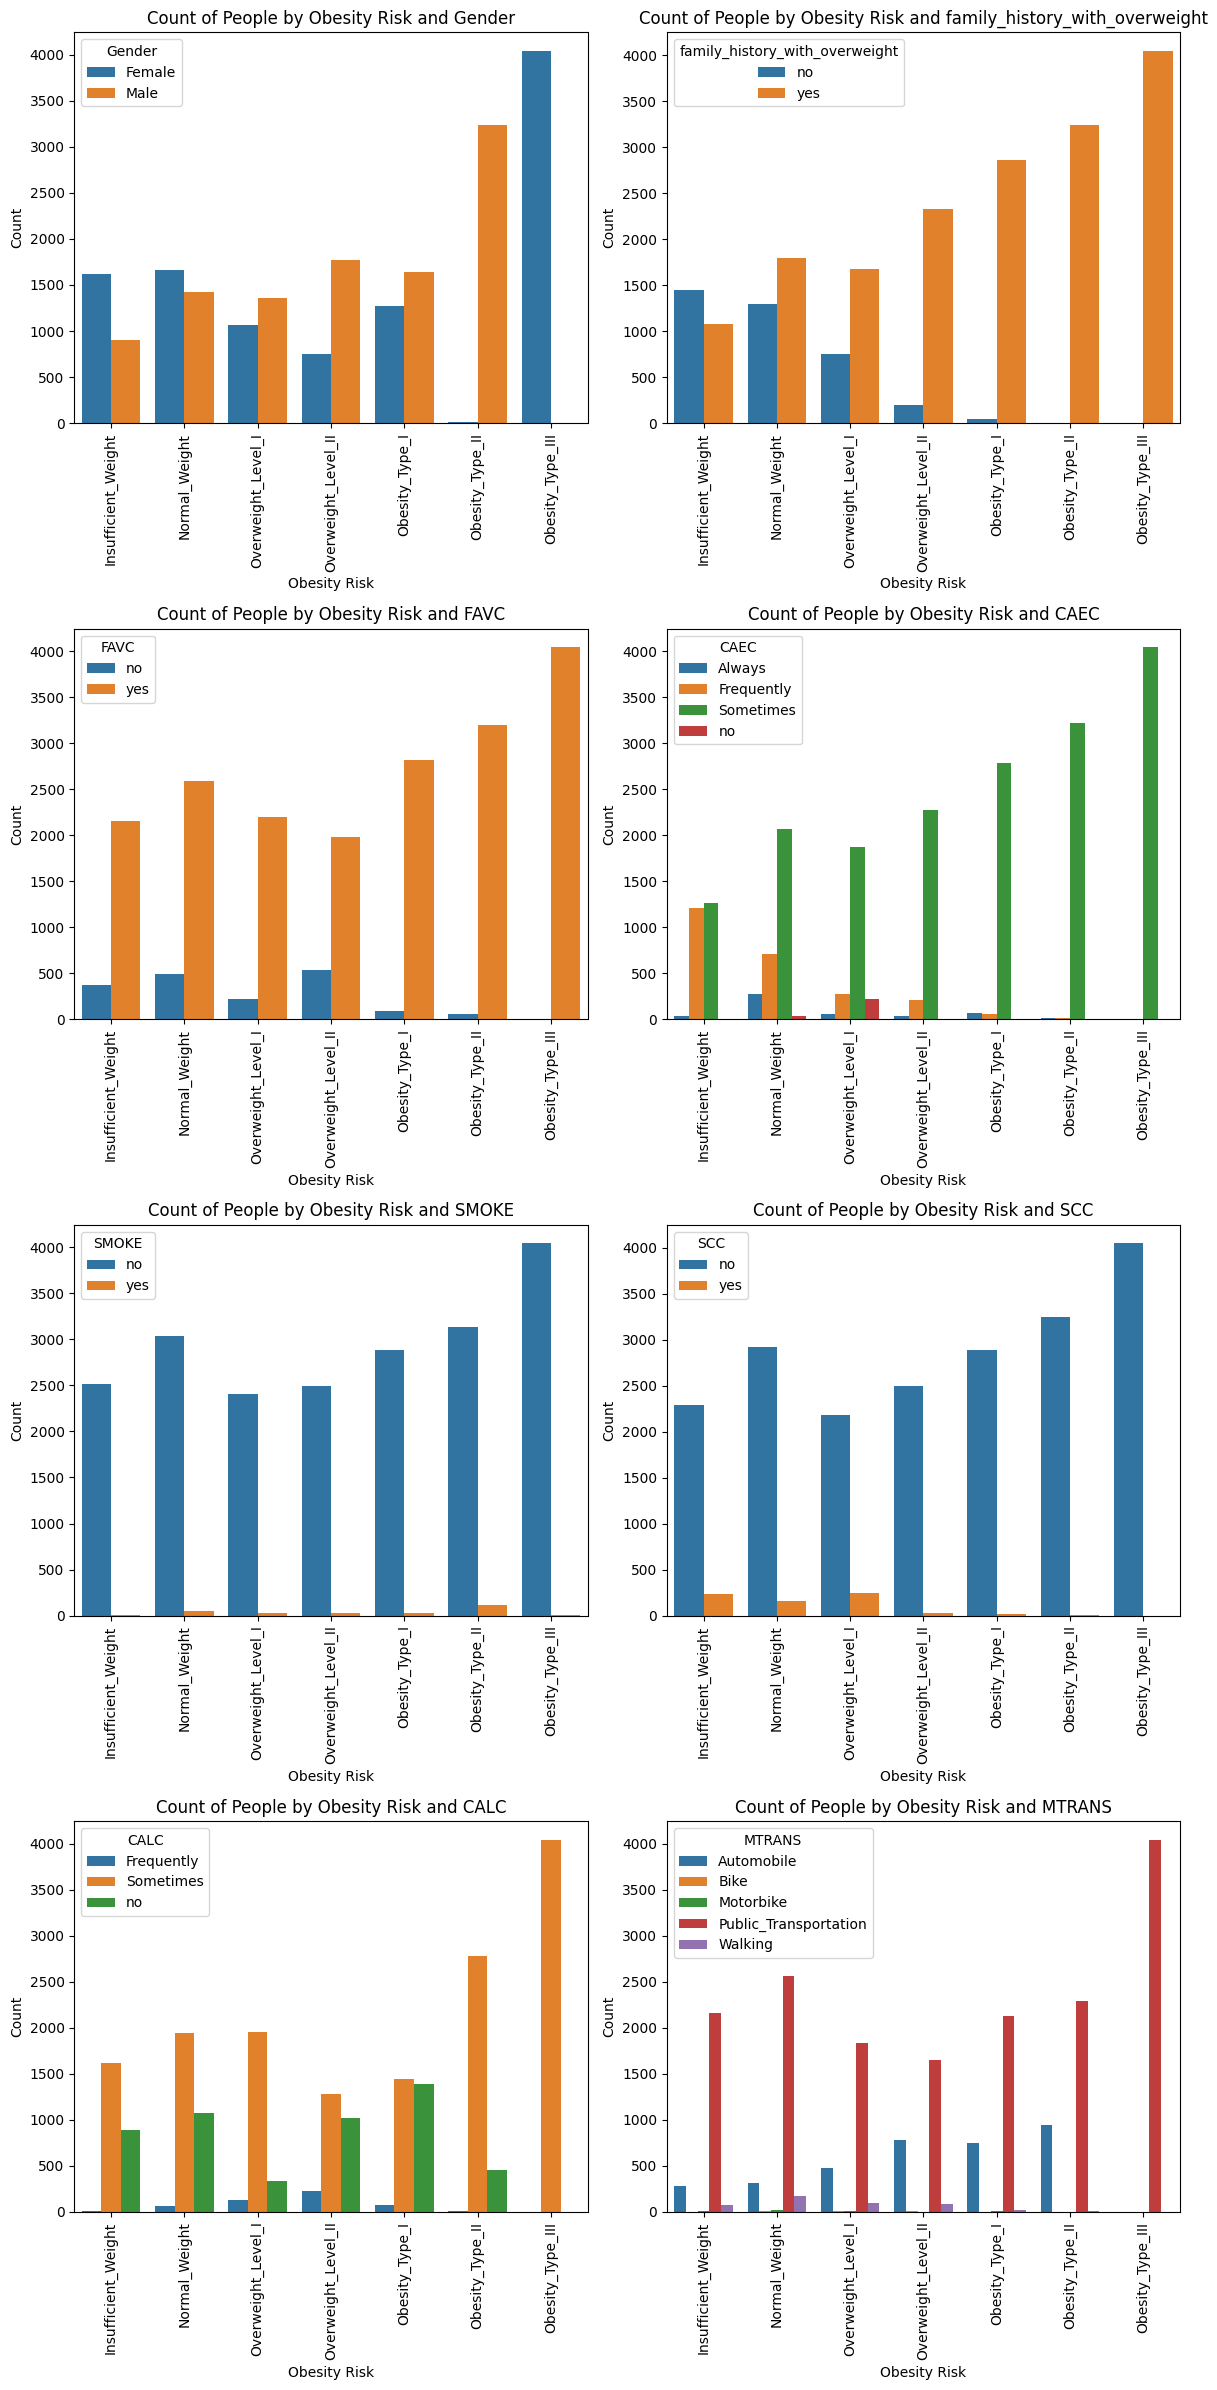

In [13]:
# Calculate number of rows and columns for subplots
# non_numerical_cols.remove('NObeyesdad')
num_plots = len(non_numerical_cols)
num_cols = 2
num_rows = math.ceil(num_plots / num_cols)
print(num_rows)

# Create subplots with specified height ratios
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 6), 
                         gridspec_kw={'height_ratios': [6] * num_rows})
plt.subplots_adjust(hspace=0.6)

# Plot bar plots for each non-numerical column
for ax, column in zip(axes.flatten(), non_numerical_cols):
    counts = df_train.groupby([column, 'NObeyesdad']).size().reset_index(name='Count')
    counts = counts.rename_axis(None, axis=1)  # Rename the index column
    sns.barplot(data=counts, x='NObeyesdad', y='Count', hue=column, order=mean_BMI, ax=ax)
    ax.set_title(f'Count of People by Obesity Risk and {column}')
    ax.set_xlabel('Obesity Risk')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=90)
    
plt.tight_layout()
plt.show()

It seems like we don't have sufficient data for Female with Obesity_type_II and Male with Obesity_type_III

from the barplot, we can see that as severity of Obesity increase, family history with overweight had a large effect on composition of number who were reported of the Obesity type.

you can see that we don't have significant data for people who smoke for given obesity levels. there fore SMOKE might bot offer us with enough classification insights.

## categorical label encoding

most ML models understand numerical value that's why we need to encode our categorical attributes into numerical values. we will use different kinds for encoding depending on kind on attribute

-  ordinal encoding: if order or categories matter. because some ML models assume that two nearby values are more similar than two distant values. bias-prone

- One hot encoding: give same weight and priority to all categories. bias-insensitive.

In [14]:
non_numerical_cols

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS']

In [15]:
# Name: count, dtype: int64
# CAEC
# Sometimes     17529
# Frequently     2472
# Always          478
# no              279

# CALC
# Sometimes     15066
# no             5163
# Frequently      529

In [16]:
# Define which columns to encode with which encoder
ordinal_cols = ['CAEC', 'CALC']
onehot_cols=[]
numerical_cols=numerical_columns
for col in non_numerical_cols:
    if col not in ordinal_cols:
        onehot_cols.append(col)
        
# Create the transformers
# Create transformers for categorical, numerical, and ordinal columns
onehot_encoder = OneHotEncoder(drop=None, sparse_output=False)
scaler = MinMaxScaler()
# scaler = StandardScaler()
ordinal_encoder = OrdinalEncoder(categories=[['no', 'Sometimes', 'Frequently', 'Always'], 
                                             ['no', 'Sometimes', 'Frequently']])





# Define preprocessing steps in a pipeline for ordinal columns
ordinal_pipeline = Pipeline([
    ('ordinal', ordinal_encoder),
    ('scaler', scaler)
])

# Define preprocessing steps in a pipeline for non-ordinal columns
non_ordinal_pipeline = Pipeline([
    ('onehot', onehot_encoder)
])


# Apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('non_ordinal', non_ordinal_pipeline, onehot_cols),
        ('ordinal', ordinal_pipeline, ordinal_cols),
        ('scaler', scaler, numerical_cols)
    ])


# Fit and transform the data
transformed_data = preprocessor.fit_transform(df_train)

onehot_encoder.fit(df_train[onehot_cols])

# Get feature names for one-hot encoded columns
onehot_cols_encoded = onehot_encoder.get_feature_names_out(onehot_cols)


# Combine column names
columns = list(onehot_cols_encoded) + ordinal_cols + numerical_cols

# Create DataFrame with transformed data and columns
transformed_df = pd.DataFrame(transformed_data, columns=columns)
transformed_df

,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,SMOKE_no,SMOKE_yes,SCC_no,SCC_yes,...,CALC,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI
0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.5,0.222192,0.475586,0.338497,0.500000,0.661099,0.881787,0.000000,0.488237,0.365327
1,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.085106,0.209260,0.142792,0.500000,0.666667,0.500000,0.333333,0.500000,0.250503
2,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.085106,0.497391,0.088577,0.440267,0.137228,0.455189,0.288682,0.836792,0.101073
3,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.5,0.147931,0.496002,0.732007,1.000000,0.666667,0.337031,0.489288,0.390099,0.759261
4,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.5,0.375342,0.883049,0.434708,0.839832,0.323824,0.489924,0.655991,0.465861,0.302178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.5,0.236959,0.602336,0.596452,0.959792,0.666667,0.575905,0.443506,0.098340,0.562992
20754,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.5,0.085106,0.494613,0.087262,1.000000,1.000000,0.000000,0.666667,0.500000,0.100422
20755,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.129809,0.703030,0.528177,0.703909,0.666667,0.500000,0.386013,0.599220,0.451497
20756,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.422403,0.475590,0.353174,0.835619,0.323824,0.572419,0.000000,0.486917,0.380521


We will explore different classifiers and assess their performance.

 - Decision Tree Classifier,

 - Random Forest Classifier,

 - XGBoost Classifier,

 - AdaBoost.
 
 - LGM
 
 - CATBOOST

## Decision Tree Classifier

 uses a set of rules used to classify data into categories by establishing cut-off criteria for categories and priotizing most decisive attributes first.

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(transformed_df, targets, test_size=0.2, random_state=42)

# Create the decision tree classifier
DTC = DecisionTreeClassifier()

# Train the classifier on the training data
DTC.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = DTC.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8422447013487476


## Random Forest Classifier



In [18]:
RFC=RandomForestClassifier()

# Train the classifier on the training data
RFC.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = RFC.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8998073217726397


In [19]:
# Label encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(targets)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(transformed_df,y, test_size=0.2, random_state=42)

XGB=XGBClassifier()

# Train the classifier on the training data
XGB.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = XGB.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9065510597302505


## CATBOOST

In [20]:
df_train=df_train.drop(['NObeyesdad'], axis=1)

In [21]:
# Label encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(targets)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(transformed_df,y, test_size=0.2, random_state=42)

CBC=CatBoostClassifier(verbose=False)

# Train the classifier on the training data
CBC.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = CBC.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9060693641618497
